# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS Module - Data Engineering and Machine Learning Operations in Business (MLOPs)** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Creating a Feature View.
3. Training datasets creation - splitting into train and test sets.
4. Training the model.
5. Register the model to Hopsworks Model Registry.

https://github.com/simran-padam/LSTM-Multivariate-Time-Series/blob/main/LSTM_Multivariate_Time_Series.ipynb

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages
We start with importing some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# Importing the packages and libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to Hopsworks Feature Store so we can retrieve the Feature Groups and select features for training data.

In [2]:
# Importing the hopsworks module for interacting with the Hopsworks platform
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/556180
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve the feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_prices',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_calendar_fg = fs.get_feature_group(
    name='dk_calendar',
    version=1,
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `timestamp` in `1_feature_backfill` we can now join them together for the `electricity_fg`, `weather_fg` and `danish_holiday_fg`.

`join_type` specifies the type of join to perform. An inner join refers to only retaining the rows based on the keys present in all joined DataFrames.

In [4]:
# Select features for training data and join them together and except duplicate columns
selected_features_training = electricity_fg.select_all()\
    .join(weather_fg.select_except(["timestamp", "datetime", "hour"]), join_type="inner")\
    .join(danish_calendar_fg.select_all(), join_type="inner")

In [5]:
# transformation_functions = {
#         "hour": fs.get_transformation_function(name="min_max_scaler"),
#         "dk1_spotpricedkk_kwh": fs.get_transformation_function(name="min_max_scaler"),
#         "temperature_2m": fs.get_transformation_function(name="min_max_scaler"),
#         "relative_humidity_2m": fs.get_transformation_function(name="min_max_scaler"),
#         "precipitation": fs.get_transformation_function(name="min_max_scaler"),
#         "rain": fs.get_transformation_function(name="min_max_scaler"),
#         "snowfall": fs.get_transformation_function(name="min_max_scaler"),
#         "weather_code": fs.get_transformation_function(name="min_max_scaler"),
#         "cloud_cover": fs.get_transformation_function(name="min_max_scaler"),
#         "wind_speed_10m": fs.get_transformation_function(name="min_max_scaler"),
#         "wind_gusts_10m": fs.get_transformation_function(name="min_max_scaler"),
#         "dayofweek": fs.get_transformation_function(name="min_max_scaler"),
#         "day": fs.get_transformation_function(name="min_max_scaler"),
#         "month": fs.get_transformation_function(name="min_max_scaler"),
#         "year": fs.get_transformation_function(name="min_max_scaler"),
#         "workday": fs.get_transformation_function(name="min_max_scaler"),
#     }


In [5]:
# Display the first 5 rows of the selected features
selected_features_training.show(5)

Finished: Reading data from Hopsworks, using ArrowFlight (3.94s) 


,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1682280000000,2023-04-23 20:00:00+00:00,2023-04-23,20,1.02178,10.4,74.0,0.0,0.0,0.0,3.0,100.0,7.6,10.1,6,23,4,2023,0
1,1678816800000,2023-03-14 18:00:00+00:00,2023-03-14,18,0.77461,0.5,88.0,0.0,0.0,0.0,0.0,0.0,11.6,22.7,1,14,3,2023,1
2,1697259600000,2023-10-14 05:00:00+00:00,2023-10-14,5,-0.01551,9.8,71.0,0.0,0.0,0.0,1.0,23.0,29.5,54.7,5,14,10,2023,0
3,1657170000000,2022-07-07 05:00:00+00:00,2022-07-07,5,1.15795,15.0,90.0,0.1,0.1,0.0,51.0,59.0,16.6,31.3,3,7,7,2022,1
4,1647597600000,2022-03-18 10:00:00+00:00,2022-03-18,10,1.48754,8.4,60.0,0.0,0.0,0.0,0.0,0.0,21.9,45.4,4,18,3,2022,1


A `Feature View` stands between the **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create a **Feature View** which stores a metadata of our data. Having the **Feature View** we can create a **Training Dataset**.

In order to create Feature View we can use `fs.get_or_create_feature_view()` method.

We can specify parameters:

- `name` - Name of the feature view to create.
- `version` - Version of the feature view to create.
- `query` - Query object with the data.

In [6]:
# Getting or creating a feature view named 'dk1_electricity_training_feature_view'
version = 1
feature_view_training = fs.get_or_create_feature_view(
    name='dk1_electricity_training_feature_view',
    version=version,
    query=selected_features_training,
)

In [ ]:
# # Getting or creating a feature view named 'dk1_electricity_training_feature_view'
# version = 1
# feature_view_training = fs.get_or_create_feature_view(
#     name='lstm_dk1_electricity_training_feature_view',
#     version=version,
#     transformation_functions=transformation_functions,
#     query=selected_features_training,
# )

## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks, a training dataset is generated from a query defined by the parent FeatureView, which determines the set of features.

**Training Dataset may contain splits such as:** 
* Training set: This subset of the training data is utilized for model training.
* Validation set: Used for evaluating hyperparameters during model training. *(We have not included a validation set for this project)*
* Test set: Reserved as a holdout subset of training data for evaluating a trained model's performance.

Training dataset is created using `fs.training_data()` method.

In [7]:
# Retrieve training data from the feature view 'feature_view_training', assigning the features to 'X'.
df, _ = feature_view_training.training_data(
    description = 'LSTM Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (3.44s) 


In [8]:
df.sort_values(by='timestamp', ascending=True, inplace=True)
df = df.reset_index(drop=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20493 entries, 0 to 20492
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             20493 non-null  int64  
 1   datetime              20493 non-null  object 
 2   date                  20493 non-null  object 
 3   hour                  20493 non-null  int32  
 4   dk1_spotpricedkk_kwh  20493 non-null  float64
 5   temperature_2m        20493 non-null  float64
 6   relative_humidity_2m  20493 non-null  float64
 7   precipitation         20493 non-null  float64
 8   rain                  20493 non-null  float64
 9   snowfall              20493 non-null  float64
 10  weather_code          20493 non-null  float64
 11  cloud_cover           20493 non-null  float64
 12  wind_speed_10m        20493 non-null  float64
 13  wind_gusts_10m        20493 non-null  float64
 14  dayofweek             20493 non-null  int32  
 15  day                

In [11]:
df.head()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1640995200000,2022-01-01 00:00:00+00:00,2022-01-01,0.000000,0.374101,0.426339,1.000000,0.0,0.0,0.0,0.04,1.0,0.255924,0.293403,0.833333,0.0,0.0,0.0,0.0
1,1640998800000,2022-01-01 01:00:00+00:00,2022-01-01,0.043478,0.367453,0.424107,1.000000,0.0,0.0,0.0,0.04,1.0,0.255924,0.243056,0.833333,0.0,0.0,0.0,0.0
2,1641002400000,2022-01-01 02:00:00+00:00,2022-01-01,0.086957,0.368895,0.426339,0.986667,0.0,0.0,0.0,0.04,1.0,0.244866,0.246528,0.833333,0.0,0.0,0.0,0.0
3,1641006000000,2022-01-01 03:00:00+00:00,2022-01-01,0.130435,0.370601,0.426339,1.000000,0.0,0.0,0.0,0.04,1.0,0.200632,0.230903,0.833333,0.0,0.0,0.0,0.0
4,1641009600000,2022-01-01 04:00:00+00:00,2022-01-01,0.173913,0.364663,0.426339,0.986667,0.0,0.0,0.0,0.04,1.0,0.167457,0.187500,0.833333,0.0,0.0,0.0,0.0


In [11]:
# Select features and target
features = df.drop(columns=['dk1_spotpricedkk_kwh','datetime','date','timestamp'])
target = df['dk1_spotpricedkk_kwh']

# Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Normalize the target
target = target.values.reshape(-1, 1)
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target)

# Convert back to DataFrame for easier handling
features_scaled = pd.DataFrame(features_scaled, index=features.index, columns=features.columns)
target_scaled = pd.DataFrame(target_scaled, index=features.index, columns=['dk1_spotpricedkk_kwh'])

In [12]:
from sklearn.model_selection import train_test_split

def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features.iloc[i:i+time_steps].values)
        y.append(target.iloc[i+time_steps].values)
    return np.array(X), np.array(y)

time_steps = 24  # Use the past 24 hours to predict the next hour
X, y = create_sequences(features_scaled, target_scaled, time_steps)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])), # Set to True for multiple LSTM layers
    LSTM(50, return_sequences=False), # Set to False for the last LSTM layer
    Dense(1) # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_test, y_test)) # Increase epochs for better performance

Epoch 1/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 2/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 3/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 4/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/12
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 12/12
512/512 ━━━━━━━━━━━━━━━

In [20]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and the true values to their original scale
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Calculate performance metrics (e.g., RMSE)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculate performance metrics

rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f'RMSE: {np.sqrt(rmse)}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
RMSE: 0.5668964713210933
MAE: 0.2334098916906344
MSE: 0.10327971119742395
R²: 0.8762503465569197


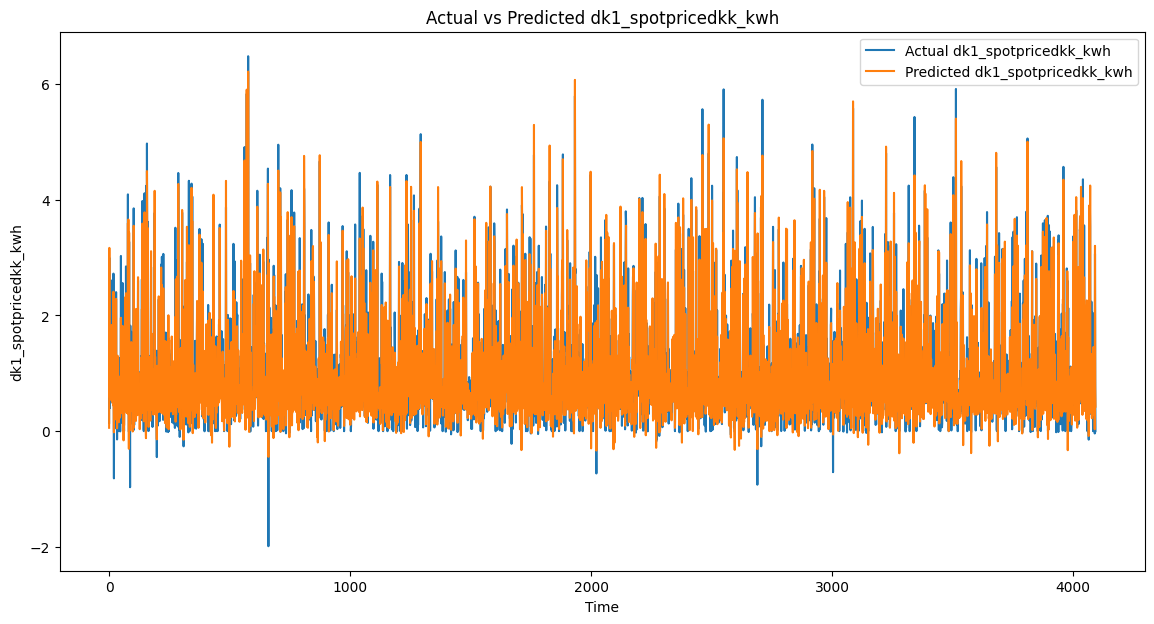

In [21]:
import matplotlib.pyplot as plt

# Plotting the true values and the predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual dk1_spotpricedkk_kwh')
plt.plot(y_pred_inverse, label='Predicted dk1_spotpricedkk_kwh')
plt.title('Actual vs Predicted dk1_spotpricedkk_kwh')
plt.xlabel('Time')
plt.ylabel('dk1_spotpricedkk_kwh')
plt.legend()
plt.show()

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


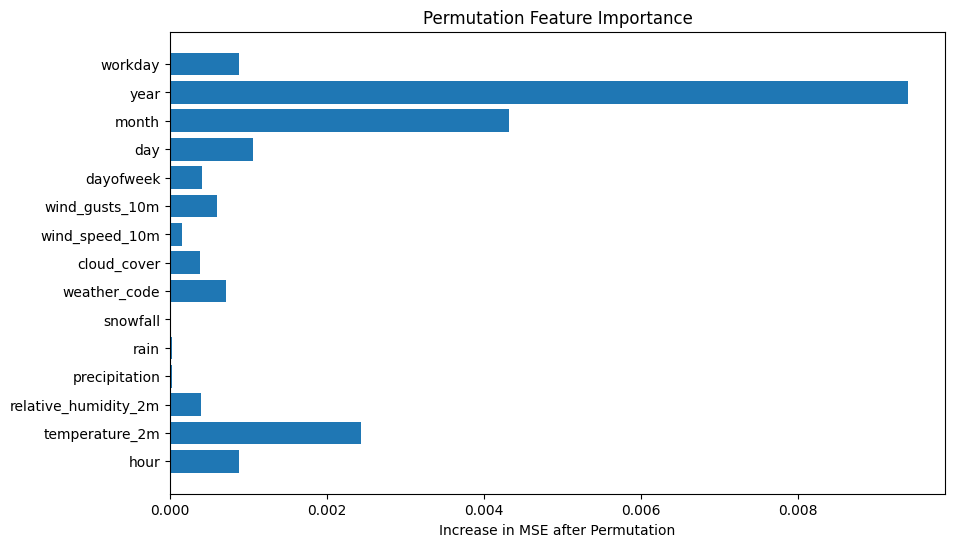

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to calculate permutation feature importance
def permutation_feature_importance(model, X_val, y_val, feature_names):
    baseline_mse = mean_squared_error(y_val, model.predict(X_val))
    importances = []

    for col in range(X_val.shape[2]):
        X_val_permuted = np.copy(X_val)
        np.random.shuffle(X_val_permuted[:, :, col])
        permuted_mse = mean_squared_error(y_val, model.predict(X_val_permuted))
        importances.append(permuted_mse - baseline_mse)

    return np.array(importances), feature_names

# Calculate feature importance
importances, feature_names = permutation_feature_importance(model, X_test, y_test, features.columns)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Increase in MSE after Permutation')
plt.title('Permutation Feature Importance')
plt.show()

### <span style="color:#2656a3;"> ⛳️ Dataset with train and test splits</span>

Here we define our train and test splits for traning the model.

In [12]:
df = df.drop(['timestamp', 'datetime', 'date'], axis=1)

In [13]:
# Splitting the data into training and testing data sets with 80% of the data for training and 20% for testing
train_size = int(len(df) * 0.8)

X_train, X_test = df[:train_size], df[train_size:]

In [14]:
y_train = X_train.pop('dk1_spotpricedkk_kwh')
y_test = X_test.pop('dk1_spotpricedkk_kwh')

In [15]:
# Displaying the first 5 rows of the test dataset (X_test)
X_test.head(5)

,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
16394,0.173913,0.328125,0.960000,0.017143,0.017143,0.0,0.68,1.0,0.157978,0.152778,0.333333,0.466667,0.909091,0.5,1.0
16395,0.217391,0.323661,0.973333,0.017143,0.017143,0.0,0.68,1.0,0.156398,0.146701,0.333333,0.466667,0.909091,0.5,1.0
16396,0.260870,0.321429,0.973333,0.005714,0.005714,0.0,0.68,1.0,0.150079,0.143229,0.333333,0.466667,0.909091,0.5,1.0
16397,0.304348,0.321429,0.946667,0.000000,0.000000,0.0,0.04,1.0,0.145340,0.140625,0.333333,0.466667,0.909091,0.5,1.0
16398,0.347826,0.325893,0.933333,0.000000,0.000000,0.0,0.04,1.0,0.140600,0.133681,0.333333,0.466667,0.909091,0.5,1.0


In [ ]:
xscaler = MinMaxScaler() #not outlier sensitive as comapred to Standard Scaler
yscaler = MinMaxScaler()

xscaler.fit(X_train.loc[:, keep_list_final])
yscaler.fit(y_train)

X_scaled_tr = xscaler.transform(X_train.loc[:, keep_list_final])
y_scaled_tr = yscaler.transform(y_train)

pd.DataFrame(X_scaled_tr).head(2)

## <span style="color:#2656a3;">🗃 Window timeseries</span>

In [16]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

For this case, let’s assume that given the past 10 days observation, we need to forecast the next 5 days observations.

In [17]:
n_past = 240 # Observations for 10 days
n_future = 120 # Predictions for the next 5 day 
n_features = 15 # Number of features

In [18]:
X_train = split_series(X_train,n_past, n_future)
y_train = split_series(y_train,n_past, n_future)

InvalidIndexError: (slice(0, 240, None), slice(None, None, None))

In [ ]:
# Now convert both the train and test data into samples using the split_series function.

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test = split_series(X_test.values,n_past, n_future)
y_test = split_series(y_test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

## <span style="color:#2656a3;">🧬 Modeling</span>

For Modeling we initialize the `XGBoost Regressor`.

The XGBoost Regressor is a powerful and versatile algorithm known for its effectiveness in a wide range of regression tasks, including predictive modeling and time series forecasting. Specifically tailored for regression tasks, it aims to predict continuous numerical values. The algorithm constructs an ensemble of regression trees, optimizing them to minimize a specified loss function, commonly the mean squared error for regression tasks. Ultimately, the final prediction is derived by aggregating the predictions of individual trees.

As shown in the above feature importance plot features like `temperature`, `day`, `hour` and `month` are most important for predicting the dependent variable. 

## <span style='color:#2656a3'>🗄 Model Registry</span>

The Model Registry in Hopsworks enable us to store the trained model. The model registry centralizes model management, enabling models to be securely accessed and governed. We can also save model metrics with the model, enabling the user to understand performance of the model on test (or unseen) data.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>
A model schema defines the structure and format of the input and output data that a machine learning model expects and produces, respectively. It serves as a **blueprint** for understanding how to interact with the model in terms of input features and output predictions. In the context of the Hopsworks platform, a model schema is typically defined using the Schema class, which specifies the features expected in the input data and the target variable in the output data. This schema helps ensure consistency and compatibility between the model and the data it operates on.

## <span style="color:#2656a3;">⏭️ **Next:** Part 04: Batch Inference </span>

Next notebook we will use the registered model to make predictions based on the batch data.